This notebook is an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [15]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt

PATH='data/'

In [3]:
df = pd.read_feather(f'{PATH}train')
df_test = pd.read_feather(f'{PATH}test')
df.set_index('row_num', inplace=True)
df_test.set_index('row_num', inplace=True)
yl = np.load(f'{PATH}yl.npy')
emb_szs = np.load(f'{PATH}emb_szs.npy')
emb_szs1 = [(c[0].item(),c[1].item()) for c in emb_szs]
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)
y_range

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


(0, 10.003955841064453)

In [4]:
emb_szs

array([[    7,     4],
       [    8,     4],
       [   16,     8],
       [    8,     4],
       [  138,    50],
       [21880,    50],
       [12738,    50],
       [12578,    50],
       [ 7045,    50],
       [ 4351,    50]])

In [5]:
n = len(df)
#train_ratio = 0.75
train_ratio = 0.8
train_size = int(n * train_ratio); train_size
val_idx = list(range(train_size, len(df)))
len(val_idx)

123847

In [6]:
cat_vars = ['locale', 'day_of_week', 'agent_id', 'traffic_type', 'entry_page', 'path_1',
    'path_2', 'path_3', 'path_4', 'path_5']

contin_vars = ['hour_of_day', 'session_duration', 'no_of_ids']
df.shape

(619235, 13)

In [7]:
# def inv_y(a): return np.exp(a)

# def exp_rmspe(y_pred, targ):
#     targ = inv_y(targ)
#     pct_var = (targ - inv_y(y_pred))/targ
#     return math.sqrt((pct_var**2).mean())

In [37]:
def inv_y(a): return np.exp(a)
def rmse(y_pred, targ):
    return sqrt(mean_squared_error(inv_y(targ), inv_y(y_pred)))

In [38]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl, cat_flds=cat_vars, bs=128,test_df=df_test)

In [39]:
m = md.get_learner(emb_szs1, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [40]:
m.summary

<bound method StructuredLearner.summary of MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(7, 4)
    (1): Embedding(8, 4)
    (2): Embedding(16, 8)
    (3): Embedding(8, 4)
    (4): Embedding(138, 50)
    (5): Embedding(21880, 50)
    (6): Embedding(12738, 50)
    (7): Embedding(12578, 50)
    (8): Embedding(7045, 50)
    (9): Embedding(4351, 50)
  )
  (lins): ModuleList(
    (0): Linear(in_features=323, out_features=1000, bias=True)
    (1): Linear(in_features=1000, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True)
    (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=1, bias=True)
  (emb_drop): Dropout(p=0.04)
  (drops): ModuleList(
    (0): Dropout(p=0.001)
    (1): Dropout(p=0.01)
  )
  (bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True)
)>

In [41]:
m.lr_find()

 60%|█████▉    | 2321/3871 [00:19<00:12, 121.81it/s, loss=1.36] 

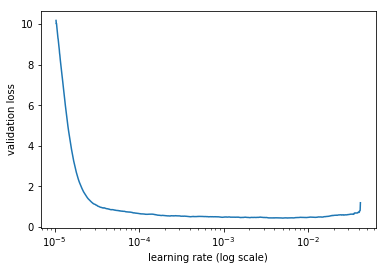

In [12]:
m.sched.plot()

### Sample

In [42]:
lr = 5e-5
m.fit(lr, 3, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                           
    0      0.440407   0.410438   28.335683 
    1      0.336534   0.3288     28.267697                      
    2      0.31161    0.304097   27.196677                      


[array([0.3041]), 27.19667695752731]

In [43]:
m.fit(lr, 3, cycle_len=1, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                           
    0      0.281597   0.297529   27.568235 
    1      0.273765   0.294064   27.296012                      
    2      0.277129   0.292254   27.423306                      


[array([0.29225]), 27.423306067007207]

In [44]:
m.fit(lr, 3, cycle_len=1, metrics=[rmse])

epoch      trn_loss   val_loss   rmse                           
    0      0.266088   0.291638   27.336    
    1      0.263574   0.291026   27.327075                      
    2      0.252886   0.29078    27.390394                      


[array([0.29078]), 27.390394414438]

In [45]:
m.save('val0')
m.load('val0')

In [46]:
pred_test=m.predict(True)

In [47]:
pred_test = np.exp(pred_test)
pred_test

array([[ 22.01427],
       [ 57.44089],
       [  2.62322],
       [ 61.63913],
       [ 21.66468],
       [  9.79949],
       [  6.73199],
       [104.39974],
       [ 10.06217],
       [ 25.73559],
       [  3.02582],
       [ 18.38167],
       [  5.12318],
       [  1.18773],
       [  3.33489],
       [ 12.84537],
       [ 10.43955],
       [  3.46846],
       [  3.16309],
       [ 20.10306],
       ...,
       [ 42.73017],
       [ 16.15582],
       [  7.82976],
       [  4.12263],
       [ 24.42853],
       [ 12.27954],
       [ 27.52805],
       [ 21.02433],
       [ 12.69996],
       [ 10.67869],
       [  4.44839],
       [  8.27257],
       [  3.50362],
       [  8.79419],
       [ 20.25055],
       [ 16.07931],
       [  4.15148],
       [ 20.36464],
       [  7.22816],
       [ 11.56828]], dtype=float32)

In [49]:
df_test['hits']=pred_test

In [50]:
csv_fn=f'{PATH}tmp/sub.csv'
df_test.reset_index(inplace=True)
df_test.head()

,row_num,locale,day_of_week,agent_id,traffic_type,entry_page,path_1,path_2,path_3,path_4,path_5,hour_of_day,session_duration,no_of_ids,hits
0,988681,6,1,2,5,2,3541,2,1,1,1,0.562680,2.675364,-0.064040,22.014267
1,988666,3,4,10,1,84,2,2104,8152,1,1,0.414898,1.915716,0.947697,57.440891
2,988665,4,7,10,4,3,12935,2,1,1,1,0.414898,-0.215244,-0.064040,2.623225
3,988664,3,2,0,1,1,2,2292,2291,1,1,0.858246,3.088073,0.947697,61.639130
4,988663,3,5,10,2,2,4046,2,5283,1,1,1.006029,-0.169204,0.947697,21.664677


In [52]:
df_test[['row_num','hits']].to_csv(csv_fn, index=False)
FileLink(csv_fn)

/home/ubuntu/fastai/courses/dl1/data/trivago/tmp/sub.csv